# Create an IMDb Language Model, and Movie Review Classifier 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## 1. Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb_sample/data_save.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [6]:
%%time
# Throws a BrokenProcessPool error, takes many tries to complete successfully
#    Why is there is there one epoch?
count = 0
error = True
while error:
    try: 
        data_lm = TextDataBunch.from_csv(path, 'texts.csv')
        error = False
        print(f'failure count is {count}\n')
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


failure count is 1

Wall time: 1min 32s


By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [7]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [8]:
data = load_data(path)

### 1A. Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [9]:
%%time
# Throws a BrokenProcessPool error, takes many tries to complete successfully
#    Why is there is there one epoch?
count = 0
error = True
while error:
    try: 
        data = TextClasDataBunch.from_csv(path, 'texts.csv')
        data.show_batch()
        error = False
        print(f'failure count is {count}\n')
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


failure count is 0

Wall time: 22.1 s


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### 1B. Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [10]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [11]:
data.train_ds[0][0]

Text xxbos 1st watched 8 / xxunk / 2001 - 3 out of xxunk - xxmaj tobe xxmaj hooper ) : xxmaj scary , yet xxunk makes sense ) portrayal of a relative of the xxmaj marquis xxmaj de xxmaj sade carrying out the same sadistic acts and enjoying it that supposedly his predecessor did . xxmaj this xxmaj tobe xxmaj hooper film really does n't do a whole lot different than his similar in style xxmaj freddy xxmaj krueger movies with the same star ( xxmaj freddy himself - xxmaj robert xxmaj englund ) playing a xxunk xxunk xxmaj marquis xxmaj de xxmaj sade and his relative ) . xxmaj it is also seems like it wants to really poke at xxmaj christianity but then loses that in the end much to my xxunk but leaving an inconsistent feel to the movie . xxmaj could have been much worse if excesses were taken in sex and violence , but they try to keep this at a minimal despite some disgusting scenes . xxmaj my final thought is why would xxmaj hooper want to make this movie . xxmaj it obviously took awhile to 

But the underlying data is all numbers

In [12]:
data.train_ds[0][0].data[:10]

array([   2, 3831,  290,  779,  119,    0,  119, 2199,   24,  384], dtype=int64)

### 1C. Preprocessing using the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [13]:
%%time
# Throws a BrokenProcessPool error, takes many tries to complete successfully
count = 0
error = True
while error:
    try: 
        data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())
        error = False
        print(f'failure count is {count}\n')
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


failure count is 2

Wall time: 59.1 s


## 2. Build an IMDb Language Model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [14]:
# got a CUDA out of memory error with batch size of 48, downsizing to 24
# bs=48
bs = 24

### 2A. Preprocess the data, and create and save a databunch

Now let's grab the full dataset for what follows.

In [15]:
path = untar_data(URLs.IMDB)
path.ls()

[WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/data_clas.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/data_lm.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/finetuned.pth'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/finetuned_enc.pth'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ld.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ll_clas.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ll_lm.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/models'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/pretrained'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/tmp_clas'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/cross-entropy/.fastai

In [16]:
(path/'train').ls()

[WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/labeledBow.feat'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/neg'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/pos'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/unsupBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

#### This block sometimes throws BrokenProcessPool errors.  I have not found a solution on the Fastai Forum.
#### I take the brute force approach: repeat until you succeed! 
#### This can take an hour or so, because it has to do 9 epochs without error

In [17]:
%%time
# this block throws BrokenProcessPool error; only thing to do is repeat until it goes through
# takes about 1.5 hours to go, because it has to do 9 epochs without error
count = 0
error = True
while error:
    try: 
        # First preprocessing steps
        data_lm = TextList.from_folder(path).filter_by_folder(include=['train', 'test', 'unsup']).split_by_rand_pct(0.1)

        # Labeling: This is the line that throws the BrokenProcessPool error
        # Note: find out why there are 9 epochs(?) Can't get past the error.
        # After many tries, the most epochs processed before the error is 7 in 17 tries.
        data_lm = data_lm.label_for_lm()
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')
        

failure count is 14

Wall time: 30min 30s


In [23]:
data_lm = data_lm.databunch(bs=bs)
data_lm.save('data_lm.pkl')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [24]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [25]:
data_lm.show_batch()

idx,text
0,"later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj"
1,"studio that had their own agenda . xxmaj hell , even the music is bad . xxmaj many will try to paint this as the xxunk "" because of it 's sci - fi twist , but really , it 's just stupid . xxmaj save for some good visuals and decent characters , "" xxmaj the xxmaj curse xxmaj of xxmaj michael xxmaj myers "" is just about as"
2,"\n \n xxmaj rather than go into the plot line i will make some comments about things i noticed about the movie . xxmaj first off the acting is very flat , only a few of the people seem to be real enough to believe in . xxmaj my first though was poor acting , but at the end i watched some of the outtakes and these same people"
3,"of this and because of the lack of the sequel xxunk has become a dark cult classic of horror films . xxbos xxmaj an enjoyable movie , without a doubt , and very evocative of both its era and that very particular stage in any boy 's ' rites of passage ' . xxmaj but i have to say that having read the very positive comments here , i was"
4,"of his father 's friend . xxmaj he says there are jobs here a lot , but if you know xxmaj spanish and xxmaj spanish market . xxmaj so , he advice him to go xxmaj spain . xxmaj xavier gets an xxmaj eramus grand and fly to xxmaj barcelona by living his girlfriend and mother . \n \n xxmaj he first learns that the house he will stay"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

### 2B. Start with the pre-trained weights from the AWD-LSTM wikitext language model;
### use the IMBb database to train, and fine-tune to create an IMDb language model!

In [26]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


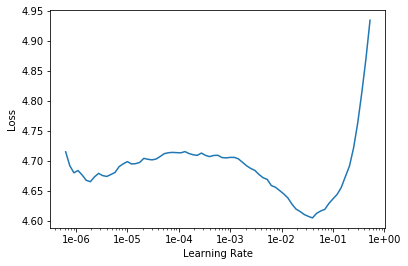

In [28]:
learn.recorder.plot(skip_end=15)

In [29]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.303022,4.167631,0.288018,37:41


In [30]:
learn.save('fit_head')

In [31]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfreeze and launch a new training.

In [32]:
learn.unfreeze()

#### Building the language model took about 7 hours on my Windows 10 64-bit machine

In [33]:
# On my Windows 10 64-bit machine, training effectively uses only the CPU; GPU usage is only 4%
# Note: why do 10 epochs, when the accuracy increases very little after a few epochs?
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.996334,3.900084,0.315758,42:28
1,3.961829,3.887378,0.321057,45:32
2,3.914547,3.856732,0.324994,56:53
3,3.827323,3.812168,0.329811,42:09
4,3.809564,3.779458,0.333386,42:15
5,3.717866,3.750784,0.336773,42:20
6,3.661979,3.722472,0.340045,42:22
7,3.637043,3.702963,0.342697,42:23
8,3.524087,3.694396,0.343879,42:22
9,3.505087,3.693372,0.344020,42:23


### 2C. save the IMDb language model (and its encoder, for later use). Test the language model.

In [39]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [40]:
learn.load('fine_tuned');

In [41]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [42]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because i was in the hospital during the day and i really like it . Religious aside , this movie was very well done . It showed the people coming together to help each other . The writing
I liked this movie because it was the best TV show i have ever seen . The acting is absolutely sensational , and there are a lot of great lines that are so hilarious . The only thing i could have done


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [44]:
learn.save_encoder('fine_tuned_enc')

## 3. IMDb Movie Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [45]:
path = untar_data(URLs.IMDB)

In [46]:
%%time
count = 0
error = True
while error:
    try: 
        data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
                     #grab all the text files in path
                     .split_by_folder(valid='test')
                     #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
                     .label_from_folder(classes=['neg', 'pos'])
                     #label them all with their folders
                     .databunch(bs=bs))

        data_clas.save('data_clas.pkl')
        error = False
        print(f'failure count is {count}\n')
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')        

failure count is 76

Wall time: 49min 1s


In [47]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [48]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj this movie was recently released on xxup dvd in the xxup us and i finally got the chance to see this hard - to - find gem . xxmaj it even came with original theatrical previews of other xxmaj italian horror classics like "" xxup xxunk "" and "" xxup beyond xxup the xxup darkness "" . xxmaj unfortunately , the previews were the best thing about this",neg
"xxbos xxmaj by 1987 xxmaj hong xxmaj kong had given the world such films as xxmaj sammo xxmaj hung 's ` xxmaj encounters of the xxmaj spooky xxmaj kind ' xxmaj chow xxmaj yun xxmaj fat in xxmaj john xxmaj woo 's iconic ` a xxmaj better xxmaj tomorrow ' , ` xxmaj zu xxmaj warriors ' and the classic ` xxmaj mr xxmaj vampire ' . xxmaj jackie xxmaj",pos
"xxbos xxmaj now that xxmaj xxunk ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both hosts of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",neg
"xxbos xxmaj sometimes a film comes along that is unique . xxmaj the xxmaj nostril xxmaj picker is one such film , xxmaj the xxmaj nostril xxmaj picker is like no other film i have ever seen , unfortunately for xxmaj the xxmaj nostril xxmaj picker & myself it 's unique for different reasons than what the filmmakers had originally intended . xxmaj read on & all shall hopefully become",neg


We can then create a model to classify those reviews and load the encoder we saved before.

In [49]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj story of a man who has unnatural feelings for a pig . xxmaj starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turned into an insane , violent mob by the crazy xxunk of it 's singers . xxmaj unfortunately it stays absurd the xxup whole time with no general narrative eventually making it just too off putting . xxmaj even those from the era should be turned off . xxmaj the cryptic dialogue would make xxmaj shakespeare seem easy to a third grader . xxmaj on a technical level it 's better than you might think with some good cinematography by future great xxmaj vilmos xxmaj zsigmond . xxmaj future stars xxmaj sally xxmaj kirkland and xxmaj frederic xxmaj forrest can be seen briefly .,xxbos xxmaj airport ' 77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman xxmaj philip xxmaj steven

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


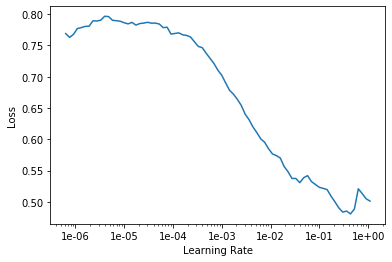

In [51]:
learn.recorder.plot()

### 3.1 Fit the classifier model using the language model, unfreezing only the last layer, save the result

In [52]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.282726,0.181254,0.933400,06:00


In [53]:
learn.save('first')

### 3.2 Fit again, unfreezing only the last two layers, and save the result

In [54]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [55]:
learn.save('second')

### 3.3 Fit again, unfreezing only the last three layers, and save the result

In [72]:
learn.load('second');

In [73]:
# CUDA out of memory error here with bs = 48
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.229619,0.152034,0.945320,08:56


In [75]:
learn.save('third')

### 3.4 Finally, fit the model again, unfreezing all the layers  only the last three layers, and save the result
#### Got CUDA out of memory error. Next time we should try bs = 16 or bs = 8. But it's OK, this won't stop us from getting our move review classifier! (See below)

In [59]:
learn.load('third');

In [60]:
# CUDA out of memory error here with bs = 24
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 8.00 GiB total capacity; 5.69 GiB already allocated; 126.97 MiB free; 143.38 MiB cached)

### 3.5 Time to test and play with our movie review classifier! 
#### We'll use the "third" model, the one we saved just before the CUDA out of memory error

In [76]:
third = learn.load('third')

### 3.5A Make a mini-database of short movie reviews
#### Important: before scrolling down, predict the ratings ('pos' or 'neg') from your own experience!

In [134]:
TEXT = OrderedDict()
ratings = OrderedDict()
TEXT[0] = "If you go, you will love it but you will regret seeing it"
TEXT[1] = "I really loved that movie, it was awesome!"
TEXT[2] = "The movie showed a lack of taste, with too many explosions."
TEXT[3] = 'The movie showed a lot of gruesome attacks'
TEXT[4] = "It was hard to understand the dialog, but the acting was OK"
TEXT[4] = "Difficult to watch but rollicking blazingly fast action sequences"
TEXT[6] = "what a disturbing frightening, horror movie"
TEXT[7] = "War is hell; this movie showed horribly detailed realistic battle scenes!"
TEXT[8] = "The plot was exciting and crazy and fun but made no sense"
TEXT[9] = "The plot was exciting and crazy and fun and made no sense"
for review in TEXT.values():
    ratings[review] = learn.predict(review)

C:\Users\cross-entropy\Anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\cross-entropy\Anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\cross-entropy\Anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\cross-entropy\Anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading

### 3.5B Predict movie ratings, based on these reviews, using our IMDb Classifier!
#### How well do you think your classifier performed?

In [135]:
for review, score in ratings.items():
    print(review, score[0],score[2].tolist())

If you go, you will love it but you will regret seeing it pos [0.28882917761802673, 0.7111707925796509]
I really loved that movie, it was awesome! pos [0.00488120224326849, 0.9951188564300537]
The movie showed a lack of taste, with too many explosions. neg [0.954279899597168, 0.04572013020515442]
The movie showed a lot of gruesome attacks pos [0.22138527035713196, 0.7786146998405457]
Difficult to watch but rollicking blazingly fast action sequences pos [0.05939968302845955, 0.9406002759933472]
what a disturbing frightening, horror movie neg [0.550888180732727, 0.44911178946495056]
War is hell; this movie showed horribly detailed realistic battle scenes! pos [0.27748027443885803, 0.7225197553634644]
The plot was exciting and crazy and fun but made no sense neg [0.6936745643615723, 0.3063254654407501]
The plot was exciting and crazy and fun and made no sense pos [0.35301223397254944, 0.646987795829773]
